In [6]:
import os
from dotenv import load_dotenv

from src.prePro import preprocess_metadata

# Load environment variables from .env file
load_dotenv()
data_dir = os.getenv('DATA_DIR')

filtered_df = preprocess_metadata(
    f'../{data_dir}/raw/chestScansMD.csv',
    f'../{data_dir}/processed/chestScansMD.csv'
)


In [2]:
import torch

# Check if CUDA (GPU) is available
if torch.cuda.is_available():
    device = torch.device("cuda")  # Use GPU
    torch.cuda.empty_cache() # empty cache
    print("Using GPU for computation.")

Using GPU for computation.


In [3]:
from PIL import Image

def load_image(image_path):
    img = Image.open(image_path).convert('L')  # Convert to grayscale
    img_resized = img.resize((300, 300))  # Resize to 300x300 for EfficientNet B2 later to be adjusted
    return img_resized

def compute_mean_std(image_paths):
    pixel_values = []
    for img_path in image_paths:
        img = load_image(img_path)
        pixel_values.append(np.array(img).flatten())
    pixel_values = np.concatenate(pixel_values)
    mean = np.mean(pixel_values)
    std = np.std(pixel_values)
    return mean, std

mean, std = compute_mean_std(metadata_df['ImageID'].apply(lambda x: f'data/origin/x-ray_scans/{x}.png'))
print(f"Mean: {mean}, Std: {std}")


Mean: 131.92835253939677, Std: 64.28788097168314


In [2]:
# Convert Gender and XrayView to numerical values
metadata_df['Gender'] = metadata_df['Gender'].map({'M': 0, 'F': 1})
metadata_df['XrayView'] = metadata_df['XrayView'].map({'PA': 0, 'AP': 1})

# Normalize the 'Age' feature
metadata_df['Age'] = (metadata_df['Age'] - metadata_df['Age'].mean()) / metadata_df['Age'].std()


In [3]:
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms

# Define the function to get the appropriate transformation
def get_transform(disease_labels):
    if 'Cardiomegaly' in disease_labels or 'Pneumothorax' in disease_labels:
        # No horizontal flip for these diseases
        transform = transforms.Compose([
            transforms.Resize((300, 300)),
            transforms.RandomRotation(degrees=10),  # Small rotation only
            transforms.ToTensor(),
            transforms.Normalize(mean=[mean], std=[std])  # Use computed mean and std
        ])
    else:
        # Horizontal flip for other diseases
        transform = transforms.Compose([
            transforms.Resize((300, 300)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomRotation(degrees=10),
            transforms.ToTensor(),
            transforms.Normalize(mean=[mean], std=[std])
        ])
    return transform

# Sample computed mean and std values for grayscale normalization
mean = 131.93 / 255  # Normalize mean to [0, 1] range
std = 64.29 / 255    # Normalize std to [0, 1] range

Batch of Images: torch.Size([32, 1, 300, 300])
Batch of Labels: torch.Size([32, 15])
Batch of Metadata: torch.Size([32, 3])


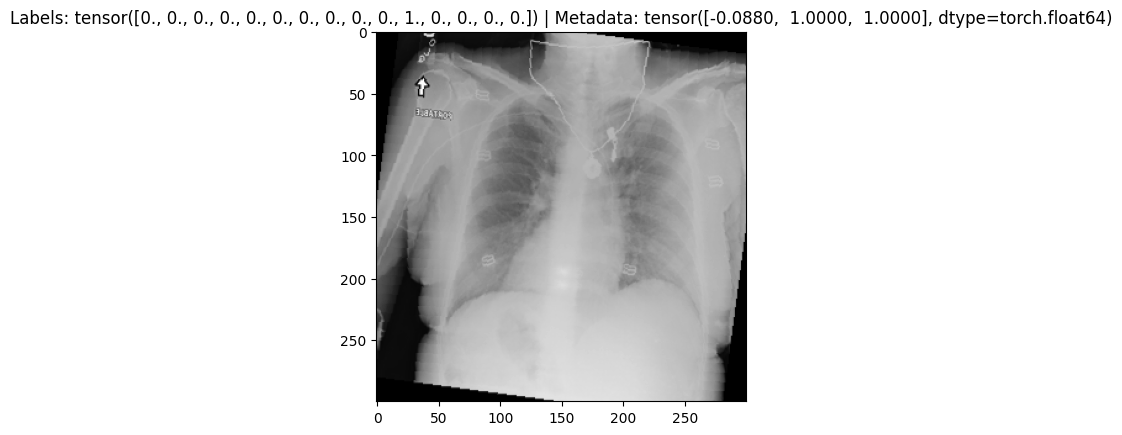

In [13]:
from torch.utils.data import DataLoader, Dataset
import torch
from PIL import Image

def load_image(image_path):
    img = Image.open(image_path).convert('L')  # Convert to grayscale
    img_resized = img.resize((300, 300))  # Resize to 300x300 for EfficientNet B2 later to be adjusted
    return img_resized

class ChestXrayDataset(Dataset):
    def __init__(self, metadata_df, transform=None):
        self.metadata_df = metadata_df
        self.transform = transform

    def __len__(self):
        return len(self.metadata_df)

    def __getitem__(self, idx):
        img_name = self.metadata_df.iloc[idx, 0]
        img_path = f'data/origin/x-ray_scans/{img_name}.png'
        image = load_image(img_path)
        # Ensure the labels are processed into a multi-hot encoded tensor
        labels = torch.tensor(self.metadata_df.iloc[idx, -1], dtype=torch.float32)  # Ensure labels are tensors
        disease_labels = self.metadata_df.iloc[idx, 1]  # String of disease labels
        transform = get_transform(disease_labels)  # Apply conditional transformations
        image = transform(image)
        # Additional features
        age = self.metadata_df.iloc[idx, 2]
        gender = self.metadata_df.iloc[idx, 3]
        xray_view = self.metadata_df.iloc[idx, 4]
        return image, labels, torch.tensor([age, gender, xray_view])

# Create the DataLoader
dataset = ChestXrayDataset(metadata_df)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=0)

# Testing the DataLoader
data_iter = iter(dataloader)
images, labels, metadata = next(data_iter)

# Now you can check the shape of the tensors
print(f"Batch of Images: {images.shape}")  # Should be [batch_size, channels, height, width]
print(f"Batch of Labels: {labels.shape}")  # Should be [batch_size, num_classes]
print(f"Batch of Metadata: {metadata.shape}")  # Should be [batch_size, 3] for age, gender, xray_view

# Visualize the first image and metadata in the batch
plt.imshow(images[0].cpu().numpy().transpose(1, 2, 0), cmap='gray')  # Display as grayscale image
plt.title(f"Labels: {labels[0]} | Metadata: {metadata[0]}")
plt.show()